#### Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap
import scipy.cluster.hierarchy as sch
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, f1_score
from sklearn.inspection import permutation_importance

#### Load the antibody and metadata

In [2]:
cytokine_data =pd.read_csv("plasma_cytokine_concentrations_by_olink_batchCorrected_data.tsv", sep='\t')
cytokine_data.head()

,164,257,255,241,203,362,27,204,91,201,...,1105,1350,1014,1206,1074,962,977,1276,1107,1339
P05231,-1.704808,1.794292,2.289689,0.407219,3.987000,2.852765,2.135374,3.306833,-0.097922,2.707216,...,1.282233,0.952928,6.252213,0.813924,1.917906,0.784828,0.693544,0.985119,2.205746,0.661882
P51671,1.288651,1.340785,1.229750,0.844083,0.872274,0.574991,1.129469,0.799069,0.739053,0.868556,...,0.403758,0.838164,0.671814,1.028016,0.720238,1.445627,1.013858,0.675515,0.453537,1.597383
P22301,-0.243633,1.501559,0.991612,1.133978,1.286612,0.725158,0.816148,0.631312,0.619274,0.896654,...,1.400123,0.645030,0.907016,1.704405,1.121091,2.051229,0.701235,1.072940,1.798974,0.817529
P48061,2.180355,0.946419,0.946419,0.946419,0.946419,0.946419,0.946419,0.946419,0.946419,0.946419,...,1.090756,0.763631,0.975684,1.118790,1.486206,0.968724,1.388107,0.956147,1.207521,0.951545
P10145,3.620721,1.784098,0.757749,1.654095,2.638551,6.638959,2.199917,0.541005,2.787221,1.845383,...,0.954589,0.856566,3.871315,1.393911,2.794962,1.729611,2.545905,0.890055,2.028145,3.439376


In [3]:
metadata =pd.read_csv("subject_specimen.tsv", sep='\t')
metadata

,specimen_id,subject_id,dataset,timepoint,infancy_vac,biological_sex,date_of_boost
0,1,1,2020_dataset,0,wP,Female,2016-09-12
1,2,1,2020_dataset,1,wP,Female,2016-09-12
2,3,1,2020_dataset,3,wP,Female,2016-09-12
3,4,1,2020_dataset,7,wP,Female,2016-09-12
4,5,1,2020_dataset,14,wP,Female,2016-09-12
...,...,...,...,...,...,...,...
891,1486,169,2023_dataset,-14,aP,Male,2023-09-05
892,1487,169,2023_dataset,0,aP,Male,2023-09-05
893,1494,171,2023_dataset,-30,wP,Female,2023-11-13
894,1496,171,2023_dataset,-14,wP,Female,2023-11-13


## 1. Descriptive Statistics

#### (i) Cytokine Data

In [4]:
cytokine_data = cytokine_data.T
cytokine_data.reset_index(inplace=True)
cytokine_data.rename(columns={"index": "specimen_id"}, inplace=True)
cytokine_data.info()
cytokine_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 46 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   specimen_id    490 non-null    object 
 1   P05231         490 non-null    float64
 2   P51671         490 non-null    float64
 3   P22301         490 non-null    float64
 4   P48061         490 non-null    float64
 5   P10145         490 non-null    float64
 6   P80098         490 non-null    float64
 7   P01133         490 non-null    float64
 8   P13232         490 non-null    float64
 9   P13500         490 non-null    float64
 10  O14625         490 non-null    float64
 11  Q99616         490 non-null    float64
 12  P50591         490 non-null    float64
 13  Q07325         490 non-null    float64
 14  P60568         490 non-null    float64
 15  Q14116         490 non-null    float64
 16  O95760         490 non-null    float64
 17  O43508         490 non-null    float64
 18  Q99731    

,P05231,P51671,P22301,P48061,P10145,P80098,P01133,P13232,P13500,O14625,...,P09919,P13725,P40933,P49771,P78380,Q16552,Q8NEV9_Q14213,Q969D9,Q96PD4,Q9P0M4
count,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,...,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000
mean,1.528682,1.024204,1.077846,1.051807,1.436974,1.204682,1.192093,1.447346,1.018791,1.065110,...,1.252349,1.547483,1.026429,1.069530,1.334775,1.564071,1.103448,4.694658,1.915753,1.169814
std,1.444059,0.344353,0.499850,0.287863,1.696649,0.858868,0.797685,1.509278,0.278003,0.511874,...,0.870165,1.415374,0.245883,0.266203,1.040691,1.625959,0.746431,12.244231,2.823156,0.632783
min,-1.704808,0.070472,-0.243633,0.437484,-1.266029,-1.008360,-0.887213,-0.695068,0.362464,-0.266499,...,-0.473828,-1.684260,0.240316,0.216061,-0.919851,-1.021253,-0.931959,-48.221134,-2.162932,-0.597048
25%,0.686018,0.771274,0.753237,0.909183,0.546595,0.716642,0.677015,0.557114,0.837636,0.760066,...,0.709506,0.658730,0.873278,0.894344,0.662827,0.536575,0.694032,-0.531875,0.291911,0.825059
50%,1.059483,1.033965,0.986308,0.972928,0.934715,1.022843,1.048207,0.939669,0.999708,1.014661,...,1.026810,1.078976,1.021089,1.031258,1.022534,1.078585,1.001207,0.923553,1.010026,1.045946
75%,1.895799,1.262671,1.293746,1.129507,1.676248,1.431366,1.623426,1.787712,1.172683,1.319178,...,1.451353,2.023158,1.156549,1.228497,1.596734,2.005772,1.363270,5.499837,2.632532,1.380471
max,10.330820,2.155617,3.711567,2.887462,11.550589,8.002540,5.470604,9.188073,2.810373,3.804352,...,5.175448,10.933140,2.207731,2.031164,7.742331,9.411744,7.395139,87.441308,17.223359,6.763453


- Columns - specimen_id (489)
- Rows - Cytokines (46)

##### Metadata has 896 specimen_id while cytokine_data has 489 specimen_id. Therefore, checking which specimen ids from metadata matches to columns of cytokine_data

In [5]:
metadata['specimen_id'] = metadata['specimen_id'].astype(str)
cytokine_data['specimen_id'] = cytokine_data['specimen_id'].astype(str)

metadata_ids = set(metadata['specimen_id'])
cytokine_data_ids = set(cytokine_data['specimen_id'])

matching_ids = metadata_ids.intersection(cytokine_data_ids)

 #### (ii) Merging metadata and cytokine data (specimen_id)

In [6]:
data = pd.merge(metadata, cytokine_data, on='specimen_id', how='inner')
data

,specimen_id,subject_id,dataset,timepoint,infancy_vac,biological_sex,date_of_boost,P05231,P51671,P22301,...,P09919,P13725,P40933,P49771,P78380,Q16552,Q8NEV9_Q14213,Q969D9,Q96PD4,Q9P0M4
0,27,4,2020_dataset,0,wP,Male,2016-08-29,2.135374,1.129469,0.816148,...,1.031391,1.667745,1.061703,1.100353,1.203692,5.445630,1.147734,10.967046,5.223614,1.232578
1,28,4,2020_dataset,1,wP,Male,2016-08-29,1.800728,1.231135,0.825448,...,1.583303,1.798627,1.160272,1.206471,1.670667,5.952543,1.364294,12.299661,6.781524,1.452139
2,29,4,2020_dataset,3,wP,Male,2016-08-29,2.109282,1.033826,1.427077,...,1.614422,2.696484,1.241682,1.294116,1.909218,6.307602,1.677979,12.925924,7.325549,1.633477
3,30,4,2020_dataset,7,wP,Male,2016-08-29,0.850950,0.901822,0.234828,...,0.599882,0.013576,0.846201,0.868347,0.785884,5.013070,0.676844,11.236072,5.120205,0.752550
4,31,4,2020_dataset,14,wP,Male,2016-08-29,1.439989,0.973132,0.378317,...,0.868797,0.818622,0.959439,0.990257,0.997773,5.133656,0.947435,11.462147,5.562335,1.004786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,1342,153,2023_dataset,-14,aP,Female,2023-02-14,0.416346,1.440847,0.460231,...,-0.049466,3.602243,1.334497,1.164525,3.259599,0.936410,0.877012,12.222435,-0.218899,1.224714
486,1343,153,2023_dataset,0,aP,Female,2023-02-14,0.775845,1.675084,0.909736,...,0.377808,0.955737,1.248310,1.089142,1.016370,1.245429,1.266633,9.693401,-0.338656,1.102933
487,1350,154,2023_dataset,-30,aP,Female,2023-02-14,0.952928,0.838164,0.645030,...,0.195790,0.646778,0.995286,0.855675,0.943802,-0.182530,0.332124,0.355708,-0.161865,1.244268
488,1351,154,2023_dataset,-14,aP,Female,2023-02-14,0.944356,0.766156,0.989774,...,0.589517,0.475573,1.161850,0.917540,0.545723,-0.241768,0.777254,5.404430,0.359654,0.686807


## 2. Timepoint Analysis

#### (i) Cytokine level over time in each patient

/var/folders/6f/wh6m6kqx1sn0fxgvj7fww4wm0000gn/T/ipykernel_68400/2566662862.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


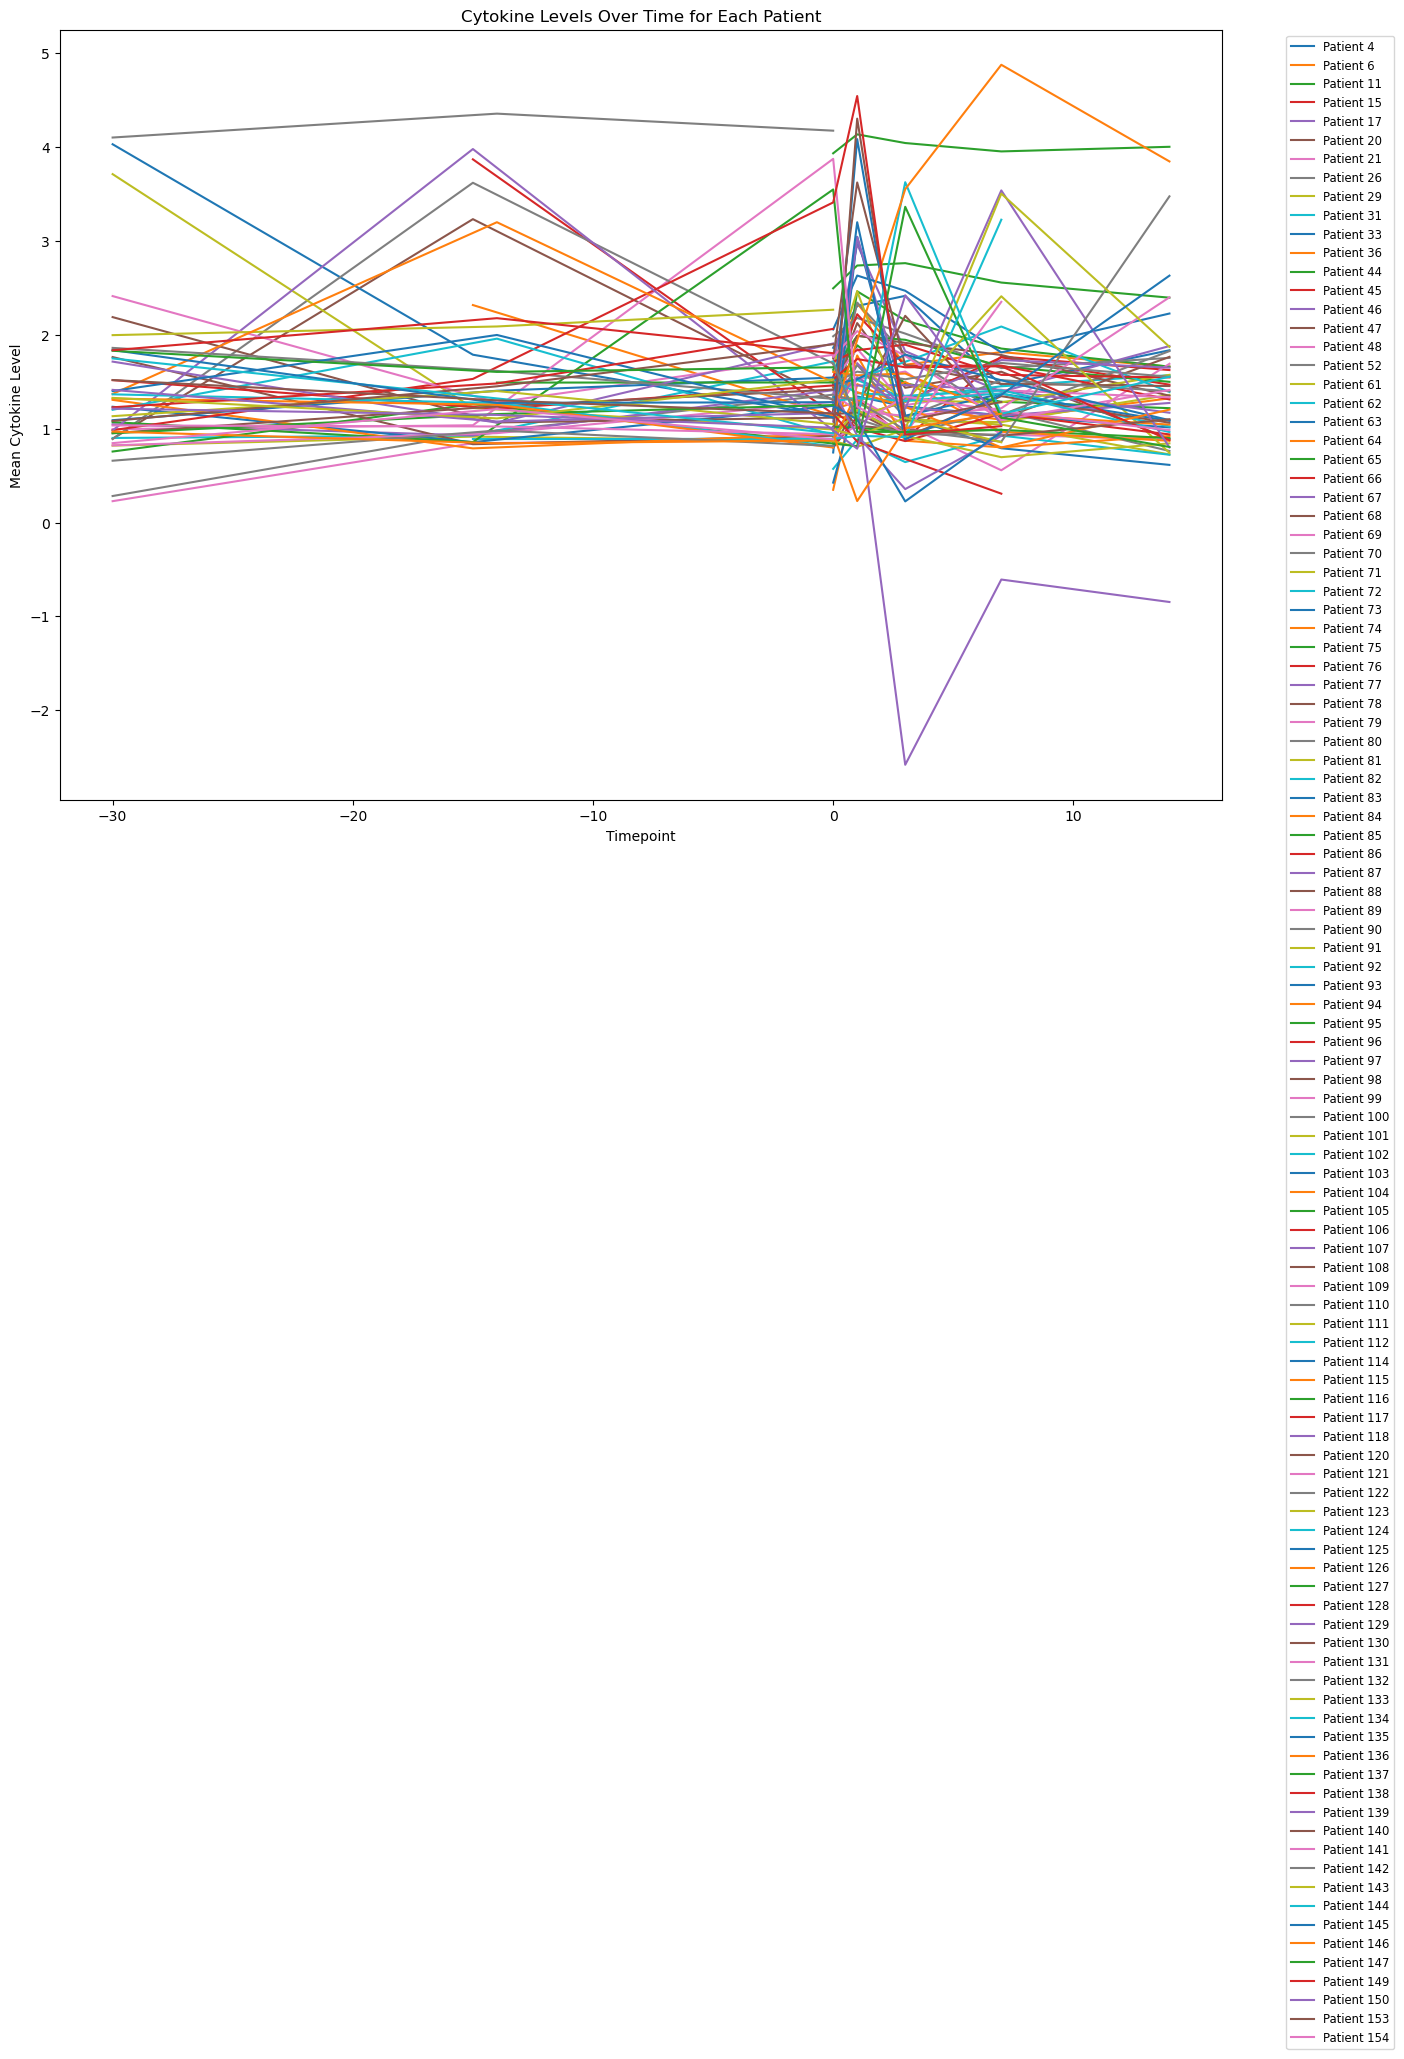

In [7]:
data.columns = data.columns.map(str)

cytokine_columns = [col for col in data.columns if col.startswith("P" or "Q")]
data[cytokine_columns] = data[cytokine_columns].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(15, 10))  
for patient_id, group in data.groupby('subject_id'):
    group = group.sort_values('timepoint')
    
    # X-axis: timepoints, Y-axis: mean cytokine levels
    x = group['timepoint']
    y = group[cytokine_columns].mean(axis=1) 

    plt.plot(x, y, label=f'Patient {patient_id}')

plt.xlabel('Timepoint')
plt.ylabel('Mean Cytokine Level')
plt.title('Cytokine Levels Over Time for Each Patient')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.xticks()  
plt.tight_layout()

plt.show()

#### (ii) Cytokine level over time in patient_id = 4

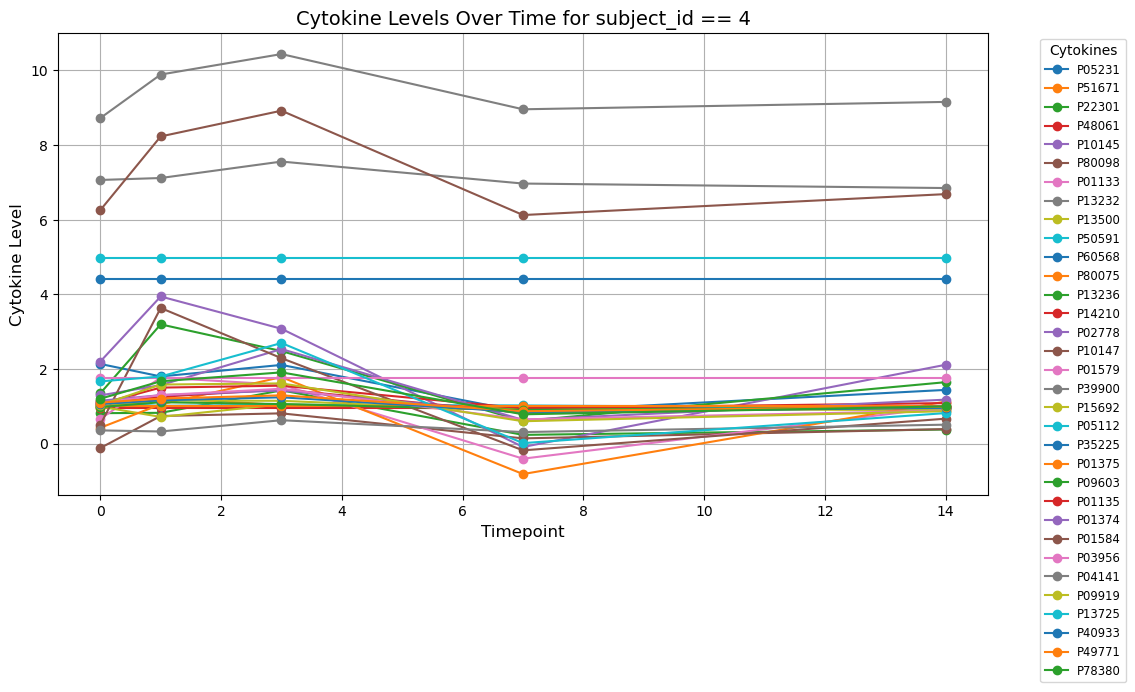

In [8]:
data.columns = data.columns.map(str)

cytokine_columns = [col for col in data.columns if col.startswith("P" or "Q")]

data[cytokine_columns] = data[cytokine_columns].apply(pd.to_numeric, errors='coerce')

subject_data = data[data['subject_id'] == 4]
subject_data = subject_data.sort_values(by='timepoint')

plt.figure(figsize=(12, 6))

for cytokine in cytokine_columns:
    plt.plot(
        subject_data['timepoint'], 
        subject_data[cytokine], 
        marker='o', 
        label=cytokine
    )

plt.title("Cytokine Levels Over Time for subject_id == 4", fontsize=14)
plt.xlabel("Timepoint", fontsize=12)
plt.ylabel("Cytokine Level", fontsize=12)
plt.legend(title="Cytokines", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.show()

#### (iii) Performing one-way ANOVA

In [9]:
# Filter data for the cytokine of interest
cytokine_column = 'P05231'
data_filtered = data[['timepoint', cytokine_column]]

# Group data by timepoint
groups = [group[cytokine_column].dropna() for _, group in data_filtered.groupby('timepoint')]

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(*groups)

print(f"ANOVA Results for {cytokine_column}:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4e}")

if p_value < 0.05:
    print("Significant differences exist between timepoints.")
else:
    print("No significant differences found between timepoints.")

ANOVA Results for P05231:
F-statistic: 2.9686
P-value: 4.6754e-03
Significant differences exist between timepoints.


In [10]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Prepare data for Tukey's HSD (pairwise comparisons between all timepoints)
tukey_results = pairwise_tukeyhsd(endog=data_filtered[cytokine_column], 
                                  groups=data_filtered['timepoint'], 
                                  alpha=0.05)

print(tukey_results.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   -30    -15    0.022    1.0 -1.1319  1.1759  False
   -30    -14   0.0746    1.0 -0.9148  1.0641  False
   -30      0  -0.1797 0.9963 -0.9351  0.5757  False
   -30      1   0.6729 0.1802 -0.1327  1.4786  False
   -30      3  -0.1165 0.9999   -0.92   0.687  False
   -30      7  -0.1566 0.9989  -0.958  0.6447  False
   -30     14  -0.2057 0.9952 -1.0363  0.6249  False
   -15    -14   0.0526    1.0 -1.1832  1.2884  False
   -15      0  -0.2017 0.9991 -1.2595   0.856  False
   -15      1   0.6509 0.6129 -0.4433  1.7451  False
   -15      3  -0.1385 0.9999 -1.2311  0.9541  False
   -15      7  -0.1786 0.9997 -1.2697  0.9124  False
   -15     14  -0.2277 0.9986 -1.3404   0.885  False
   -14      0  -0.2543 0.9874 -1.1298  0.6211  False
   -14      1   0.5983 0.4954 -0.3209  1.5175  False
   -14      3  -0.1911 0.9984 -1.1084  0.7262 

## 3. Comparative Analysis

#### (i) Effect of vaccination type on Cytokine concentration

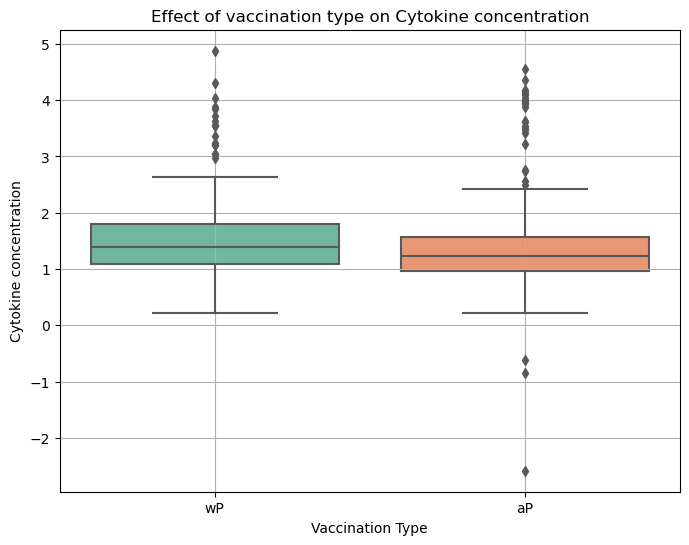

In [11]:
data['Cytokine concentration'] = data.loc[:, data.columns.str.startswith('P' or 'Q')].mean(axis=1)

plt.figure(figsize=(8, 6))
sns.boxplot(x='infancy_vac', y='Cytokine concentration', data=data, palette='Set2')
plt.title('Effect of vaccination type on Cytokine concentration')
plt.xlabel('Vaccination Type')
plt.ylabel('Cytokine concentration')
plt.grid(True)
plt.show()

#### (ii) Effect of gender on Cytokine concentration

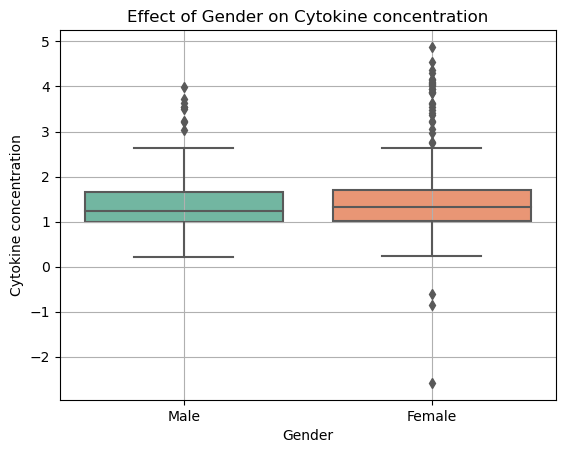

In [12]:
sns.boxplot(x='biological_sex', y='Cytokine concentration', data=data, palette='Set2')
plt.title('Effect of Gender on Cytokine concentration')
plt.xlabel('Gender')
plt.ylabel('Cytokine concentration')
plt.grid(True)
plt.show()

## 4. Correlation

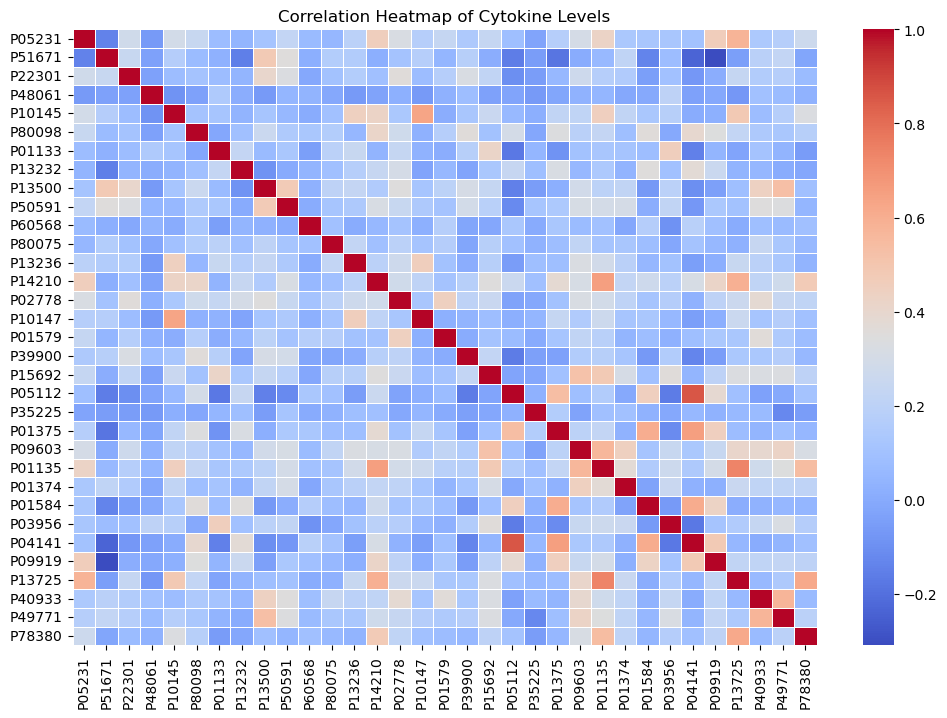

In [13]:
data_subset = data[cytokine_columns]

# Calculate the correlation matrix
correlation_matrix = data_subset.corr()

# heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Cytokine Levels')
plt.show()

###### Interpretation:
Various Cytokine subtypes like P04141, P05112, P01135, and P13725 show strong correlations with similar subtypes across different conditions. This suggests that antibody levels for these subtypes are likely influenced in parallel under certain conditions.


## 5. Dimensionality Reduction

#### (i) PCA

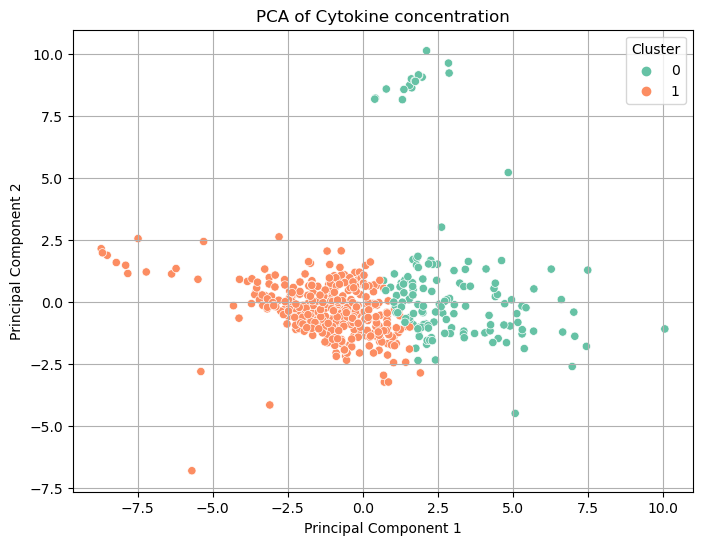

In [14]:
cytokine_columns = [col for col in data.columns if col.startswith('P' or 'Q')]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[cytokine_columns]) 

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

# Add the PCA results to the data
data['PCA1'] = pca_result[:, 0]
data['PCA2'] = pca_result[:, 1]

pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])

# Perform clustering
kmeans = KMeans(n_clusters=2, random_state=42)
data['Cluster'] = kmeans.fit_predict(data_scaled)

# Plot the results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='Set2', data=data)
plt.title('PCA of Cytokine concentration')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

#### (ii) UMAP

/Users/vaishnaveethote/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


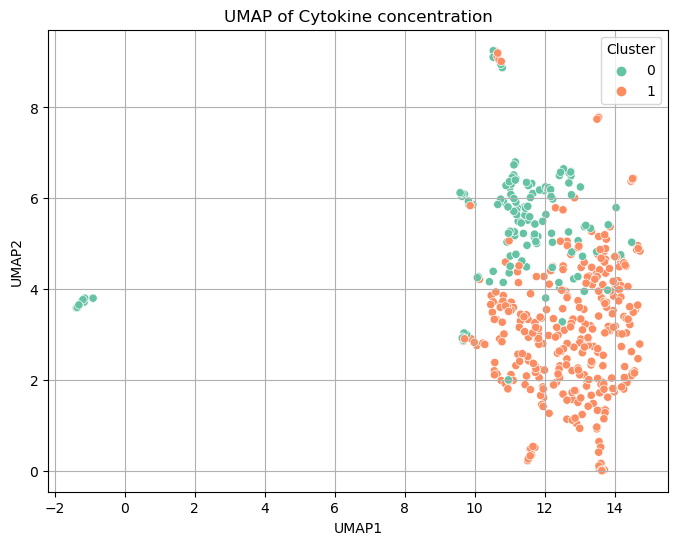

In [15]:
# Apply UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(data_scaled)

# Add the UMAP results to the data
data['UMAP1'] = umap_result[:, 0]
data['UMAP2'] = umap_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Cluster', palette='Set2', data=data)
plt.title('UMAP of Cytokine concentration')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.grid(True)
plt.show()

## 6. Clustering

#### (i) k-means clustering

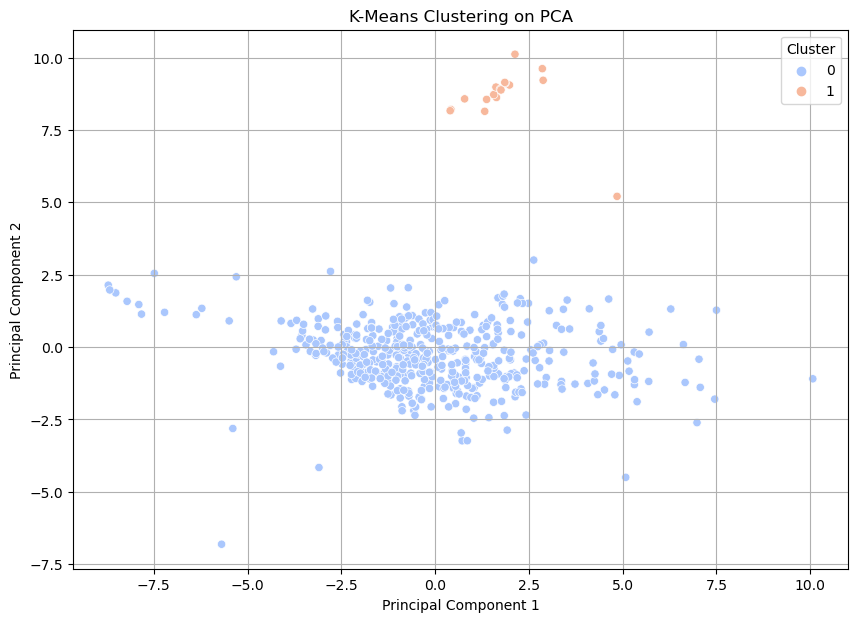

In [16]:
# Apply KMeans clustering on the PCA results
kmeans_pca = KMeans(n_clusters=2, random_state=42)
kmeans_pca_labels = kmeans_pca.fit_predict(pca_result)

# Add the KMeans cluster labels to the PCA DataFrame
pca_df['Cluster'] = kmeans_pca_labels

# Visualize the clusters in PCA space
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='coolwarm')
plt.title('K-Means Clustering on PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()


#### (ii) Hierarchial Clustering

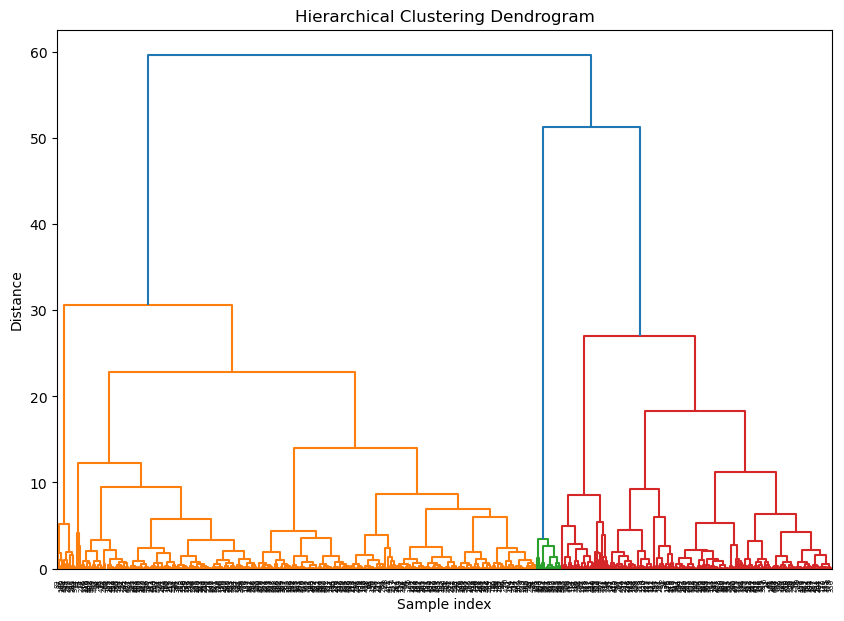

In [17]:
# Compute the linkage matrix
Z = sch.linkage(pca_result, method='ward')

# Create a dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

## 7. Logistic Regression

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters:  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Logistic Regression Accuracy: 0.6277
Accuracy: 0.6429
F1 Score: 0.6667
AUC-ROC Score: 0.6989
Classification Report:
               precision    recall  f1-score   support

          aP       0.62      0.71      0.67        49
          wP       0.67      0.57      0.62        49

    accuracy                           0.64        98
   macro avg       0.65      0.64      0.64        98
weighted avg       0.65      0.64      0.64        98



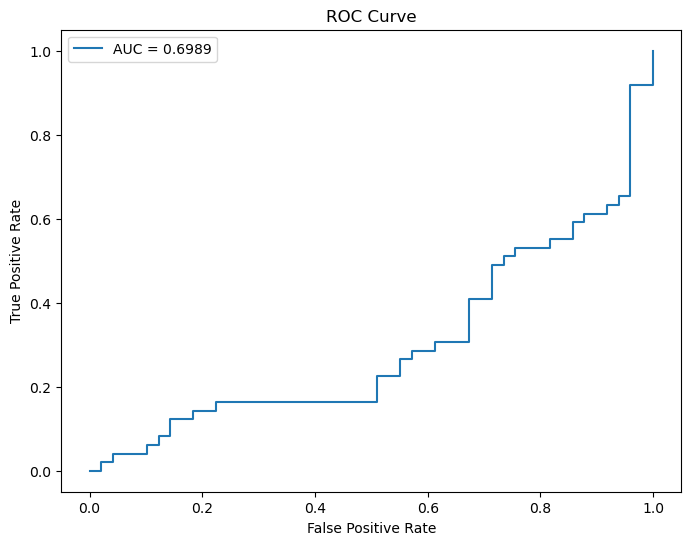

In [18]:
# Split data
X = data[cytokine_columns]  # Antibody levels (features)
y = data['infancy_vac']     # Vaccination type (target variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the logistic regression model
log_reg = LogisticRegression(max_iter=10000, random_state=42)

# Define the refined parameter grid for GridSearchCV
param_grid = [
    {'penalty': ['l1'], 'C': [0.01, 0.1, 1], 'solver': ['liblinear', 'saga']},
    {'penalty': ['l2'], 'C': [0.01, 0.1, 1], 'solver': ['lbfgs', 'liblinear']},
]

# Initialize GridSearchCV
grid_search_log_reg = GridSearchCV(estimator=log_reg, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search_log_reg.fit(X_train_scaled, y_train)

# Get the best model
best_log_reg = grid_search_log_reg.best_estimator_

# Predict on the test set
y_pred_log_reg = best_log_reg.predict(X_test_scaled)
y_probs_log_reg = best_log_reg.predict_proba(X_test_scaled)[:, 1]

# Compute accuracy, F1-score, and AUC-ROC score
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg, pos_label='aP')  # Adjust pos_label if needed
roc_auc_log_reg = roc_auc_score(y_test, y_probs_log_reg)

# Print results
print("Best parameters: ", grid_search_log_reg.best_params_)
print("Best Logistic Regression Accuracy: {:.4f}".format(grid_search_log_reg.best_score_))
print("Accuracy: {:.4f}".format(accuracy_log_reg))
print("F1 Score: {:.4f}".format(f1_log_reg))
print("AUC-ROC Score: {:.4f}".format(roc_auc_log_reg))

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_log_reg))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_log_reg, pos_label='aP')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_log_reg:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## 8. Support Vector Machine

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best SVM Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best SVM Accuracy: 0.755111976630964
Accuracy: 0.7653
F1 Score: 0.7527
AUC-ROC Score: 0.8655
Classification Report:
               precision    recall  f1-score   support

          aP       0.80      0.71      0.75        49
          wP       0.74      0.82      0.78        49

    accuracy                           0.77        98
   macro avg       0.77      0.77      0.76        98
weighted avg       0.77      0.77      0.76        98



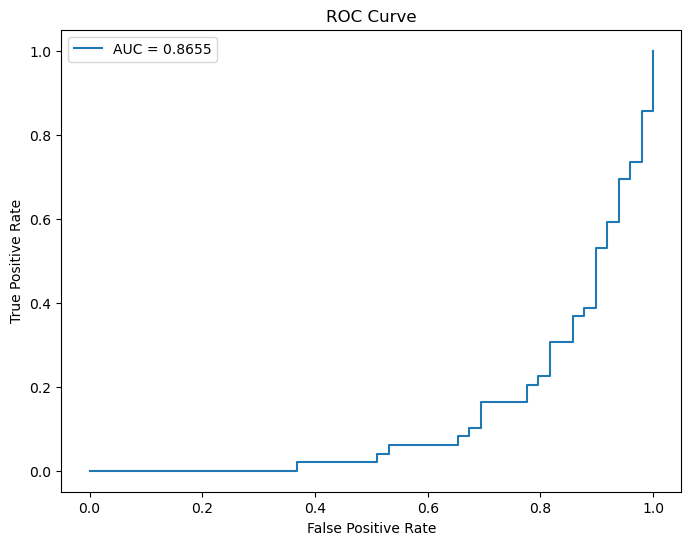

In [19]:
# SVM hyperparameter grid
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'linear']
}

# GridSearchCV for SVM
svm_grid_search = GridSearchCV(
    estimator=SVC(random_state=42, probability=True),
    param_grid=svm_param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1
)
svm_grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_svm = svm_grid_search.best_estimator_

# Predict on the test set
y_pred_svm = best_svm.predict(X_test_scaled)
y_probs_svm = best_svm.predict_proba(X_test_scaled)[:, 1]

# Compute accuracy, F1-score, and AUC-ROC score
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, pos_label='aP')  # Adjust pos_label if needed
roc_auc_svm = roc_auc_score(y_test, y_probs_svm)

# Best parameters and accuracy
print("Best SVM Parameters:", svm_grid_search.best_params_)
print("Best SVM Accuracy:", svm_grid_search.best_score_)
print("Accuracy: {:.4f}".format(accuracy_svm))
print("F1 Score: {:.4f}".format(f1_svm))
print("AUC-ROC Score: {:.4f}".format(roc_auc_svm))

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_svm, pos_label='aP')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_svm:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## 9. Random Forest

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest Accuracy: 0.7424862057773451
Accuracy: 0.7245
F1 Score: 0.7379
AUC-ROC Score: 0.8319
Classification Report:
               precision    recall  f1-score   support

          aP       0.70      0.78      0.74        49
          wP       0.75      0.67      0.71        49

    accuracy                           0.72        98
   macro avg       0.73      0.72      0.72        98
weighted avg       0.73      0.72      0.72        98



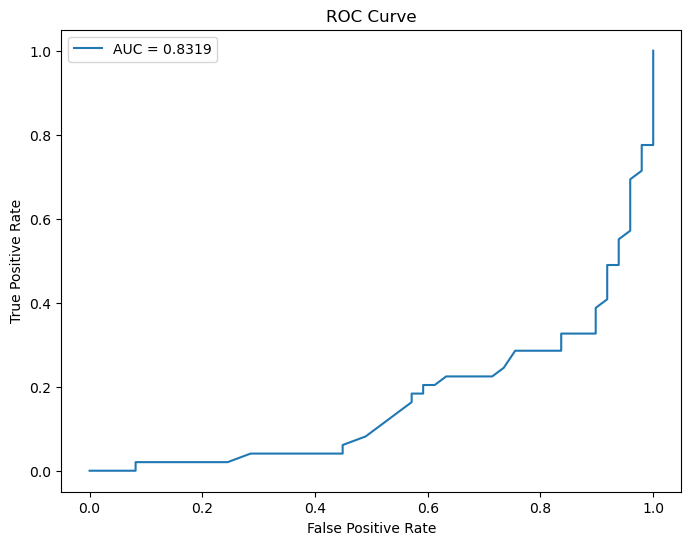

In [20]:
# Random Forest hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1
)
rf_grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_rf = rf_grid_search.best_estimator_

# Predict on the test set
y_pred_rf = best_rf.predict(X_test_scaled)
y_probs_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

# Compute accuracy, F1-score, and AUC-ROC score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, pos_label='aP')  
roc_auc_rf = roc_auc_score(y_test, y_probs_rf)

# Best parameters and accuracy
print("Best Random Forest Parameters:", rf_grid_search.best_params_)
print("Best Random Forest Accuracy:", rf_grid_search.best_score_)
print("Accuracy: {:.4f}".format(accuracy_rf))
print("F1 Score: {:.4f}".format(f1_rf))
print("AUC-ROC Score: {:.4f}".format(roc_auc_rf))

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_rf, pos_label='aP')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_rf:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## 10. XGBoost

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best XGBoost Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best XGBoost Accuracy: 0.7682570593962998
Accuracy: 0.7653
F1 Score: 0.7629
AUC-ROC Score: 0.8609
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.76        49
           1       0.76      0.78      0.77        49

    accuracy                           0.77        98
   macro avg       0.77      0.77      0.77        98
weighted avg       0.77      0.77      0.77        98



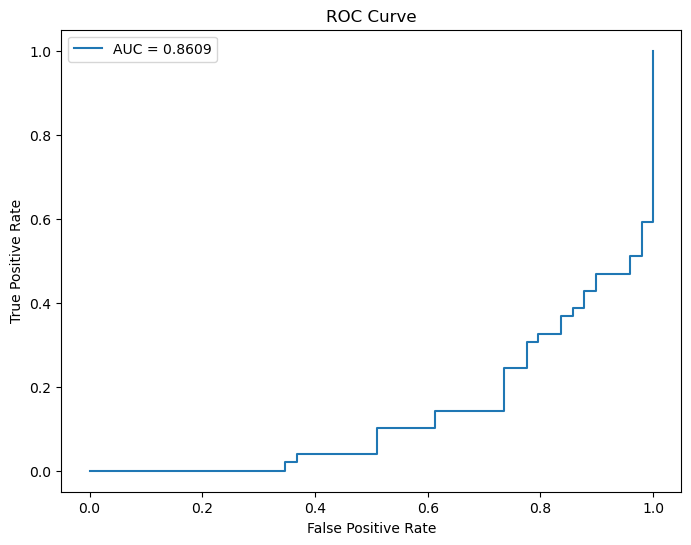

[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...................

[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...................

[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................

[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ...................

In [21]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Apply encoding on y_train
y_test_encoded = label_encoder.transform(y_test)        # Apply encoding on y_test

# Define the XGBoost model
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",  
    verbosity=0            
)

# Define parameter grid for hyperparameter tuning
param_grid = {
    "n_estimators": [100, 200, 300],   
    "max_depth": [3, 5, 7],             
    "learning_rate": [0.01, 0.05, 0.1, 0.2],   
    "subsample": [0.6, 0.8, 1.0],              
    "colsample_bytree": [0.6]        
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train_scaled, y_train_encoded)

# Get the best model
best_xgb = grid_search.best_estimator_

# Predict on the test set
y_pred_xgb = best_xgb.predict(X_test_scaled)
y_probs_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

# Compute accuracy, F1-score, and AUC-ROC score
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
f1_xgb = f1_score(y_test_encoded, y_pred_xgb, pos_label=label_encoder.transform(['aP'])[0])  # Adjust 'aP' if needed
roc_auc_xgb = roc_auc_score(y_test_encoded, y_probs_xgb)

# Best parameters and accuracy
print("Best XGBoost Parameters:", grid_search.best_params_)
print("Best XGBoost Accuracy:", grid_search.best_score_)
print("Accuracy: {:.4f}".format(accuracy_xgb))
print("F1 Score: {:.4f}".format(f1_xgb))
print("AUC-ROC Score: {:.4f}".format(roc_auc_xgb))

# Print classification report
print("Classification Report:\n", classification_report(y_test_encoded, y_pred_xgb))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_xgb, pos_label='aP')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_xgb:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [22]:
# Encode the target variable
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)  # 'aP' -> 1, 'wP' -> 0


In [23]:
# Logistic Regression
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_probs_log_reg, pos_label='aP')
roc_auc_log_reg = roc_auc_score(y_test, y_probs_log_reg)

# SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_probs_svm, pos_label='aP')
roc_auc_svm = roc_auc_score(y_test, y_probs_svm)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf, pos_label='aP')
roc_auc_rf = roc_auc_score(y_test, y_probs_rf)

# XGBoost
fpr, tpr, _ = roc_curve(y_test, y_probs_xgb, pos_label='aP')
roc_auc_xgb = roc_auc_score(y_test, y_probs_xgb)

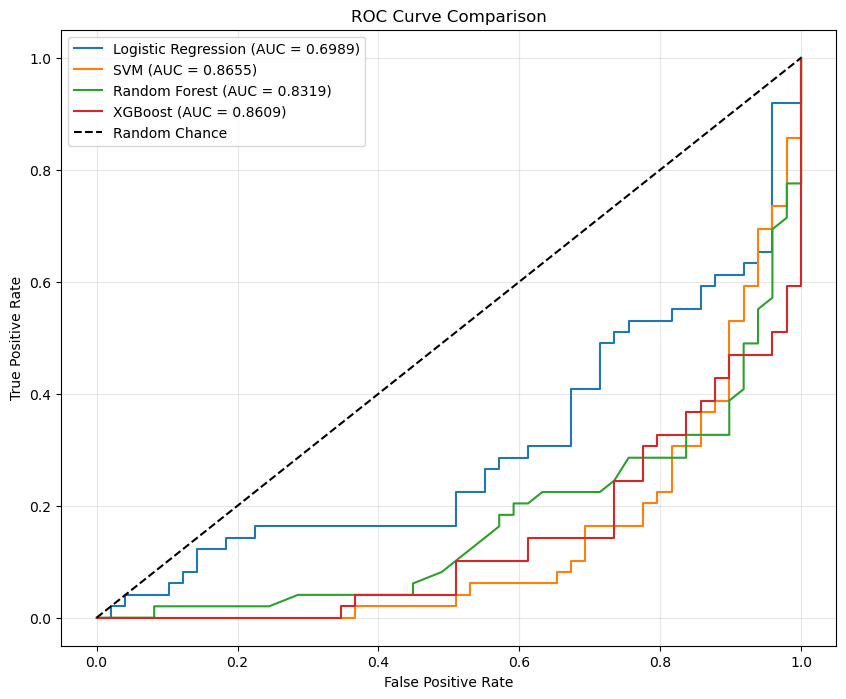

In [24]:
import matplotlib.pyplot as plt

# Plot all ROC curves
plt.figure(figsize=(10, 8))

plt.plot(fpr_log_reg, tpr_log_reg, label=f"Logistic Regression (AUC = {roc_auc_log_reg:.4f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.4f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})")
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc_xgb:.4f})")

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Add plot details
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Encode the target variable
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)  # 'aP' -> 1, 'wP' -> 0


# Logistic Regression
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_probs_log_reg, pos_label='aP')
roc_auc_log_reg = roc_auc_score(y_test, y_probs_log_reg)

# SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_probs_svm, pos_label='aP')
roc_auc_svm = roc_auc_score(y_test, y_probs_svm)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf, pos_label='aP')
roc_auc_rf = roc_auc_score(y_test, y_probs_rf)

# XGBoost
fpr, tpr, _ = roc_curve(y_test, y_probs_xgb, pos_label='aP')
roc_auc_xgb = roc_auc_score(y_test, y_probs_xgb)

import matplotlib.pyplot as plt

# Plot all ROC curves
plt.figure(figsize=(10, 8))

plt.plot(fpr_log_reg, tpr_log_reg, label=f"Logistic Regression (AUC = {roc_auc_log_reg:.4f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.4f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})")
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc_xgb:.4f})")

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Add plot details
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)
plt.show()

## 11. Feature Importance

feature importance will provide insights into which antibodies are most predictive of the target variable.

### Random Forest

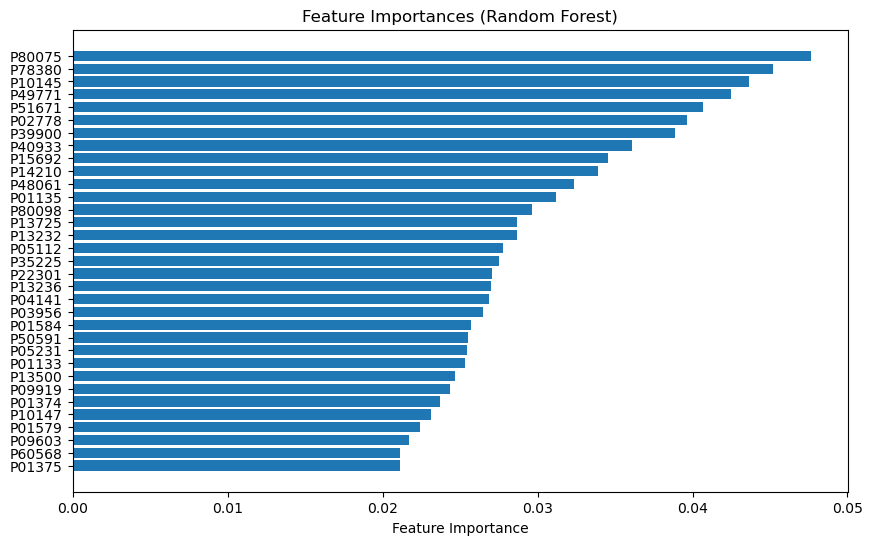

In [23]:
# Get the best Random Forest model
best_rf = rf_grid_search.best_estimator_

# Get feature importances
importances_rf = best_rf.feature_importances_

# Get feature names
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Sort feature importances in descending order
sorted_idx_rf = importances_rf.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(
    [feature_names[i] for i in sorted_idx_rf], 
    importances_rf[sorted_idx_rf], 
    align='center'
)
plt.xlabel('Feature Importance')
plt.title('Feature Importances (Random Forest)')
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.show()

### XGBoost

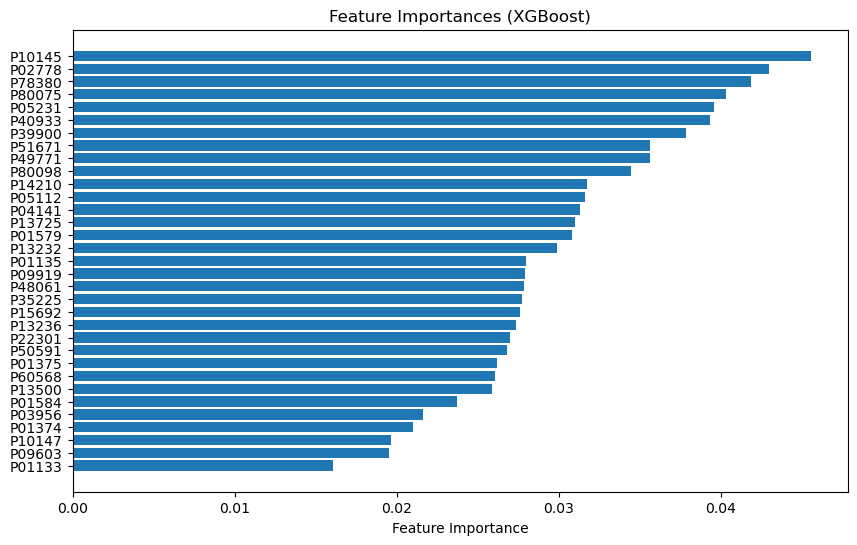

In [24]:
# Get the best XGBoost model
best_gb = grid_search.best_estimator_

# Get feature importances
importances_gb = best_gb.feature_importances_

# Get feature names
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Sort feature importances in descending order
sorted_idx_gb = importances_gb.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(
    [feature_names[i] for i in sorted_idx_gb], 
    importances_gb[sorted_idx_gb], 
    align='center'
)
plt.xlabel('Feature Importance')
plt.title('Feature Importances (XGBoost)')
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.show()

### Support Vector Machine

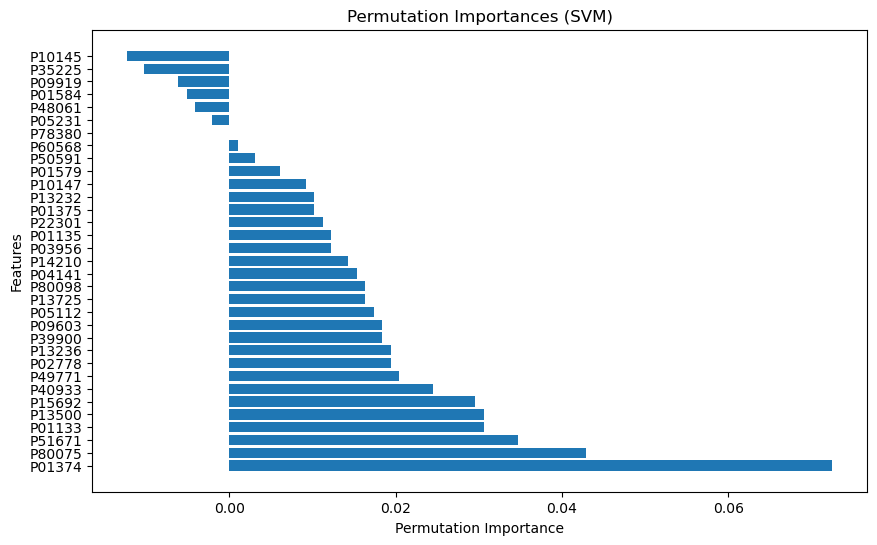

In [25]:
# Get the best model from GridSearchCV
best_svm = svm_grid_search.best_estimator_

# Compute permutation importances
result = permutation_importance(best_svm, X_test_scaled, y_test, n_repeats=10, random_state=42, scoring='accuracy')
importances = result.importances_mean

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
sorted_idx = np.argsort(importances)[::-1]

# Plot permutation importances
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx], align='center')
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Permutation Importances (SVM)')
plt.show()

### Logistic Regression

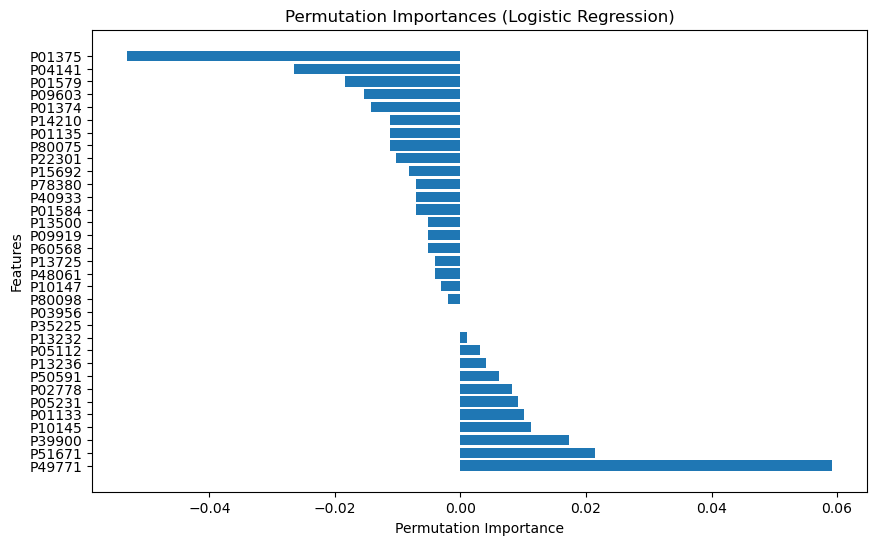

In [26]:
# Get the best model from GridSearchCV
best_log_reg = grid_search_log_reg.best_estimator_

# Compute permutation importances
result_log_reg = permutation_importance(best_log_reg, X_test_scaled, y_test, n_repeats=10, random_state=42, scoring='accuracy')
importances_log_reg = result_log_reg.importances_mean

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
sorted_idx_log_reg = np.argsort(importances_log_reg)[::-1]

# Plot permutation importances
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx_log_reg], importances_log_reg[sorted_idx_log_reg], align='center')
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Permutation Importances (Logistic Regression)')
plt.show()

## 12. Comparing Results

In [27]:
data = [
    ["Logistic Regression", f"{accuracy_log_reg:.4f}", f"{roc_auc_log_reg:.4f}"],
    ["SVM", f"{accuracy_svm:.4f}", f"{roc_auc_svm:.4f}"],
    ["Random Forest", f"{accuracy_rf:.4f}", f"{roc_auc_rf:.4f}"],
    ["XGBoost", f"{accuracy_xgb:.4f}", f"{roc_auc_xgb:.4f}"]
]

# Define headers for the table
headers = ["Model", "Accuracy", "AUROC"]

# Create a pandas DataFrame
df = pd.DataFrame(data, columns=headers)


print(df.to_string(index=False))

              Model Accuracy  AUROC
Logistic Regression   0.6429 0.6989
                SVM   0.7653 0.8655
      Random Forest   0.7245 0.8319
            XGBoost   0.7653 0.8609
